In [1]:
import pickle
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import sys
import os
import pandas as pd
from sklearn.model_selection import train_test_split

module_path = "/Users/patrickgunn/Documents/Documents - iCloud Drive/Uni Fourth Year/Full Year/Group Project/Bayesian-Neural-Network-Project/Rebuilding_Slang"
if module_path not in sys.path:
    sys.path.append(module_path)

import torchutils as tu
from torchutils.models import MLP as MultiSampleMLP

with open(path, 'rb') as f:
    results_dict = pickle.load(f)

ModuleNotFoundError: No module named 'torchutils'

In [30]:
from ucimlrepo import fetch_ucirepo 

# fetch dataset 
estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition = fetch_ucirepo(id=544) 
  
# data (as pandas dataframes) 
X = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.features 
y = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.targets.copy() 

categorical_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC','CALC','MTRANS']
# One-hot encode categorical features, dropping the first category
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)
X_encoded = X_encoded.astype({col: int for col in X_encoded.select_dtypes('bool').columns})

# Convert X_encoded to a PyTorch tensor
X_tensor = torch.tensor(X_encoded.values, dtype=torch.float32)

y['NObeyesdad'] = y['NObeyesdad'].astype('category').cat.codes

# Convert to tensor
y_tensor = torch.tensor(y['NObeyesdad'].to_numpy(), dtype=torch.long)

x_tr, x_te, y_tr, y_te = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42)

In [31]:
param_means = results_dict['optimizer']['state']['mean']
prec_factor = results_dict['optimizer']['state']['prec_factor']
prec_diag = results_dict['optimizer']['state']['prec_diag']

In [92]:
results_dict['optimizer']['state'].keys()

dict_keys(['mean', 'prec_factor', 'prec_diag', 'momentum_grad', 'step'])

In [42]:
dist = tu.distributions.LowRankMultivariateNormal(
            loc=param_means.view(-1,1),
            prec_factor=prec_factor,
            prec_diag=prec_diag
        )

model = MultiSampleMLP(input_size=23,
                        hidden_sizes=[10,10],
                        output_size=7,
                        act_func=nn.ReLU())

In [94]:
model.cpu().count()

AttributeError: 'MLP' object has no attribute 'count'

In [84]:
def predict_fn(x, mc_samples):
    noise = dist.rsample(mc_samples).t()
    preds = model(x, noise, False)
    return preds

mc_samples=1000
noise = dist.rsample(mc_samples).t()

In [90]:
preds = predict_fn(x_te, mc_samples=100)
preds_sm = nn.Softmax(dim=-1)(preds.mean(0))

k=5

print(preds_sm[0:k,:])

print(y_te[0:k])

tensor([[1.0378e-02, 9.8962e-01, 0.0000e+00, 2.0679e-39, 1.1070e-43, 5.1993e-18,
         4.6839e-27],
        [4.5275e-07, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 8.9326e-22,
         5.3395e-29],
        [1.5346e-02, 9.8465e-01, 0.0000e+00, 6.5861e-43, 0.0000e+00, 4.7800e-19,
         4.2183e-29],
        [7.6717e-03, 9.9233e-01, 7.8473e-44, 8.6249e-30, 9.2035e-33, 9.8024e-14,
         9.9572e-21],
        [4.0616e-04, 9.9959e-01, 0.0000e+00, 1.5975e-43, 0.0000e+00, 5.8016e-19,
         4.8150e-27]], grad_fn=<SliceBackward0>)
tensor([0, 4, 0, 0, 1])


tensor([-1.2802e-01, -3.8432e-02,  4.9038e-03, -6.5654e-02, -6.9623e-02,
        -4.6733e-02,  2.7587e-02,  1.0059e-02,  1.9753e-02, -2.0383e-02,
         5.4506e-02, -3.5569e-02, -1.3428e-02, -2.3779e-02, -2.8027e-02,
         2.0245e-02, -2.9723e-02,  1.6405e-02,  7.0408e-02, -7.8313e-03,
         1.0067e-03, -3.1169e-02, -1.0465e-02,  6.6321e-02, -1.4014e+00,
         4.4184e-02,  3.8711e-01,  4.6440e-01,  7.8802e-01,  6.2009e-02,
         1.6220e-01,  4.7683e-02,  2.2775e-01,  9.8003e-01, -1.5657e-01,
         3.7853e-01, -5.9142e-02, -2.6754e-01,  4.3677e-01,  9.7200e-02,
         5.1863e-01, -4.8553e-01,  1.2693e-01,  9.0965e-03, -3.3943e-01,
         4.0662e-01,  3.7232e-02,  5.0053e-01,  4.1158e-01, -4.2452e-01,
         1.2217e-01, -8.4335e-02,  1.9718e-01,  1.9423e-02,  2.6907e-01,
        -8.4123e-01,  4.6182e-01, -4.7109e-01,  7.5039e-02,  3.3644e-02,
        -1.9328e-01, -5.5566e-02, -8.0075e-02, -4.1906e-02,  1.3474e-01,
         1.2716e-01, -1.1103e-01, -2.0119e-01,  1.9

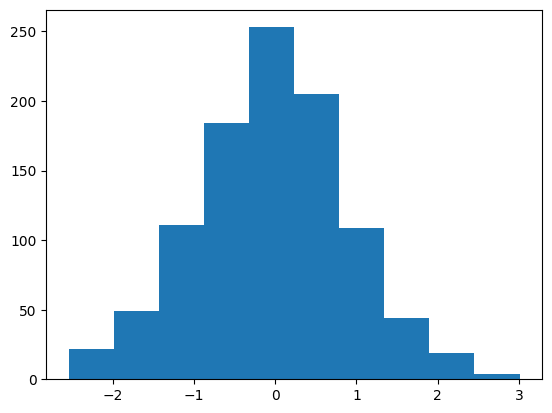

In [ ]:
plt.hist(noise[:,1])

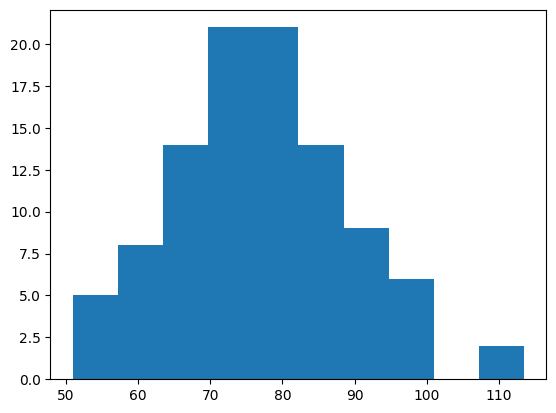

In [81]:
plt.hist(preds[:,1,1].detach().numpy())
plt.show()